# Predict Loan Default using Logistic regression

## Content
0. Introduction
1. Data Exploration
2. Exploratory Data Analysis (EDA)
3. Data Pre-processing
4. Feature Selection
5. Logistic Regression Modeling
6. Project Outcomes & Conclusion

# <center>0. Introduction

# <center>1. Data Exploration

In [1]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression


from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [2]:
#Importing the dataset

df = pd.read_excel('data.xlsx')
df.drop(['ID','year'],axis=1, inplace=True) #year는 2019년으로만 코딩되어서 제거

target = 'Status'
labels = ['Defaulter','Not-Defaulter']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

loan_limit             Gender approv_in_adv loan_type loan_purpose  \
0         cf  Sex Not Available         nopre     type1           p1   
1         cf               Male         nopre     type2           p1   
2         cf               Male           pre     type1           p1   
3         cf               Male         nopre     type1           p4   
4         cf              Joint           pre     type1           p1   

  Credit_Worthiness open_credit business_or_commercial  loan_amount  \
0                l1        nopc                  nob/c       116500   
1                l1        nopc                    b/c       206500   
2                l1        nopc                  nob/c       406500   
3                l1        nopc                  nob/c       456500   
4                l1        nopc                  nob/c       696500   

   rate_of_interest  Interest_rate_spread  Upfront_charges   term  \
0               NaN                   NaN              NaN  360.0   
1               NaN                   NaN              NaN  360.0   
2              4.56                0.2000            595.0  360.0   
3              4.25                0.6810              NaN  360.0   
4              4.00                0.3042              0.0  360.0   

  Neg_ammortization interest_only lump_sum_payment  property_value  \
0           not_neg       not_int         not_lpsm        118000.0   
1           not_neg       not_int             lpsm             NaN   
2           neg_amm       not_int         not_lpsm        508000.0   
3           not_neg       not_int         not_lpsm        658000.0   
4           not_neg       not_int         not_lpsm        758000.0   

  construction_type occupancy_type Secured_by total_units   income  \
0                sb             pr       home          1U   1740.0   
1                sb             pr       home          1U   4980.0   
2                sb             pr       home          1U   9480.0   
3                sb             pr       home          1U  11880.0   
4                sb             pr       home          1U  10440.0   

  credit_type  Credit_Score co-applicant_credit_type    age  \
0         EXP           758                      CIB  25-34   
1        EQUI           552                      EXP  55-64   
2         EXP           834                      CIB  35-44   
3         EXP           587                      CIB  45-54   
4        CRIF           602                      EXP  25-34   

  submission_of_application        LTV Region Security_Type  Status  dtir1  
0                   to_inst  98.728814  south        direct       1   45.0  
1                   to_inst        NaN  North        direct       1    NaN  
2                   to_inst  80.019685  south        direct       0   46.0  
3                  not_inst  69.376900  North        direct       0   42.0  
4                  not_inst  91.886544  North        direct       0   39.0


Inference: The Datset consists of 32 features & 148670 samples.


#### --- Feature Description ---
코딩북 참고해서 작성하기

In [3]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  object 
 1   Gender                     148670 non-null  object 
 2   approv_in_adv              147762 non-null  object 
 3   loan_type                  148670 non-null  object 
 4   loan_purpose               148536 non-null  object 
 5   Credit_Worthiness          148670 non-null  object 
 6   open_credit                148670 non-null  object 
 7   business_or_commercial     148670 non-null  object 
 8   loan_amount                148670 non-null  int64  
 9   rate_of_interest           112231 non-null  float64
 10  Interest_rate_spread       112031 non-null  float64
 11  Upfront_charges            109028 non-null  float64
 12  term                       148629 non-null  float64
 13  Neg_ammortization          14

In [4]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

loan_limit                       2
Security_Type                    2
submission_of_application        2
co-applicant_credit_type         2
Secured_by                       2
construction_type                2
Status                           2
interest_only                    2
Neg_ammortization                2
lump_sum_payment                 2
business_or_commercial           2
open_credit                      2
approv_in_adv                    2
Credit_Worthiness                2
occupancy_type                   3
loan_type                        3
total_units                      4
Gender                           4
Region                           4
loan_purpose                     4
credit_type                      4
age                              7
term                            26
dtir1                           57
rate_of_interest               131
loan_amount                    211
property_value                 385
Credit_Score                   401
income              

In [5]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 10 numerical & 21 categorical features.


In [7]:
#Checking the stats of all the columns

df.describe()

loan_amount  rate_of_interest  Interest_rate_spread  Upfront_charges  \
count  1.486700e+05     112231.000000         112031.000000    109028.000000   
mean   3.311177e+05          4.045476              0.441656      3224.996127   
std    1.839093e+05          0.561391              0.513043      3251.121510   
min    1.650000e+04          0.000000             -3.638000         0.000000   
25%    1.965000e+05          3.625000              0.076000       581.490000   
50%    2.965000e+05          3.990000              0.390400      2596.450000   
75%    4.365000e+05          4.375000              0.775400      4812.500000   
max    3.576500e+06          8.000000              3.357000     60000.000000   

                term  property_value         income   Credit_Score  \
count  148629.000000    1.335720e+05  139520.000000  148670.000000   
mean      335.136582    4.978935e+05    6957.338876     699.789103   
std        58.409084    3.599353e+05    6496.586382     115.875857   
min        96.000000    8.000000e+03       0.000000     500.000000   
25%       360.000000    2.680000e+05    3720.000000     599.000000   
50%       360.000000    4.180000e+05    5760.000000     699.000000   
75%       360.000000    6.280000e+05    8520.000000     800.000000   
max       360.000000    1.650800e+07  578580.000000     900.000000   

                 LTV         Status          dtir1  
count  133572.000000  148670.000000  124549.000000  
mean       72.746457       0.246445      37.732932  
std        39.967603       0.430942      10.545435  
min         0.967478       0.000000       5.000000  
25%        60.474860       0.000000      31.000000  
50%        75.135870       0.000000      39.000000  
75%        86.184211       0.000000      45.000000  
max      7831.250000       1.000000      61.000000

NOTE
- 연속형 변수의 표준편차가 너무 각기 다르게 나타난다. -> 스케일링 고려!
- 'term'의 대부분 코딩값은 360이다. 왜지?(코드북이 없어서 파악 못함)
- 'LTV'(주택담보가치 대비 대출이 가능한 금액)의 편차가 굉장히 크게 나타남->LTV가 작다는것은 대출 가능한 금액이 적다는것?

In [8]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
lump_sum_payment                           0         0.0
co-applicant_credit_type                   0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Status                                     0         0.0
interest_only                              0         0.0
credit_type                                0         0.0
Region                                     0         0.0
Credit_Score                               0         0.0
loan_amount                                0         0.0
business_or_commercial                     0         0.0
open_credit                                0         0.0
Credit_Worthiness                          0         0.0
loan_type                                  0         0.0
Gender                         

# <center> 2. Exploratory Data Analysis (EDA)

**본격적인 EDA를 위해 variable visualizing을 통해 파악해보도록 한다**

**1. 단일변수 파악**

            Target Variable Distribution           


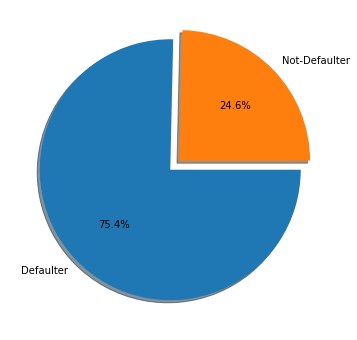

In [10]:
#Let us first analyze the distribution of the target variable

MAP={}
for e, i in enumerate(sorted(df[target].unique())):
    MAP[i]=labels[e]
#MAP={0:'Not-Survived',1:'Survived'}
df1 = df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

NOTE
- 타겟 변수는 비체납자와 체납자가 약 1:3 비율을 이루고 있다 → DATA Balancing 처리해주기

                               Visualising Categorical Features:                                


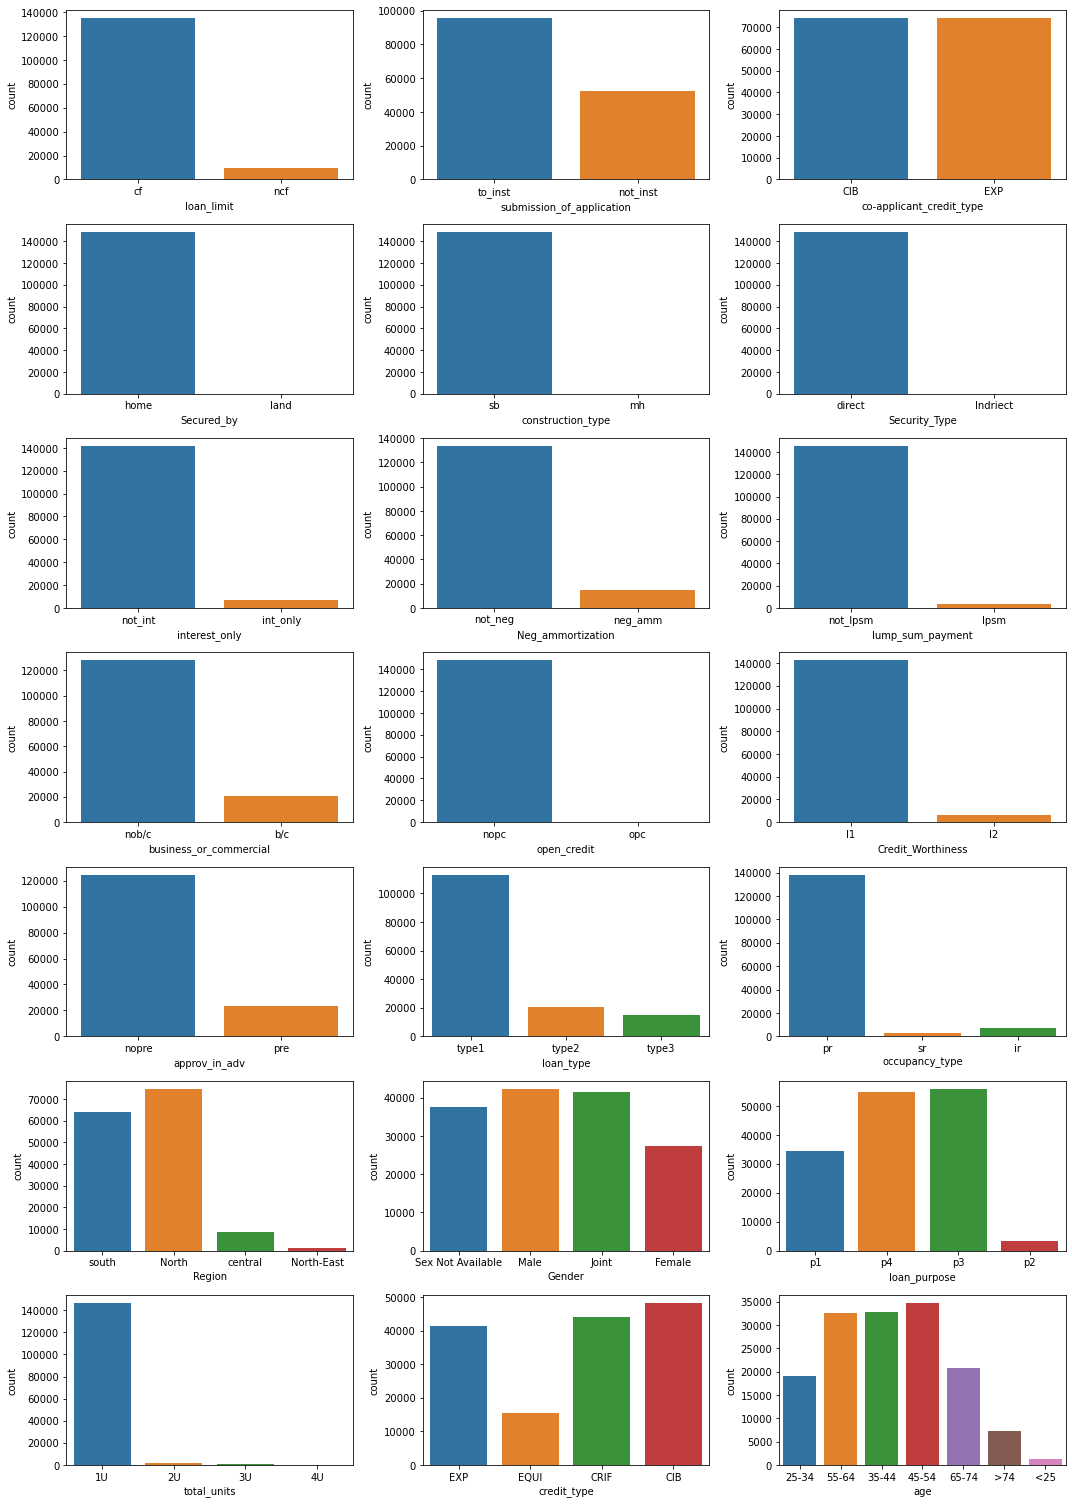

In [11]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=3
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=12:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
plt.tight_layout()
plt.show()

**Inference:** Visualizing the categorical features reveal lot of information about the dataset.

                                     Features Distribution                                      


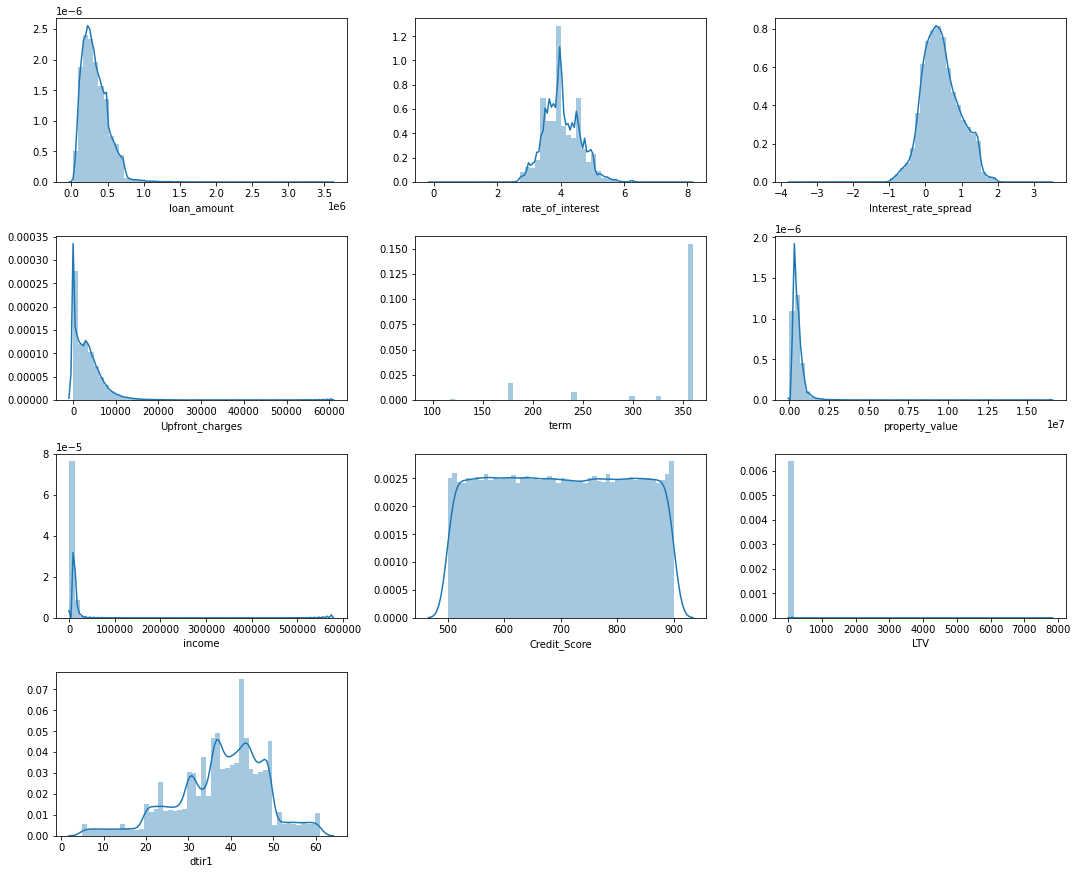

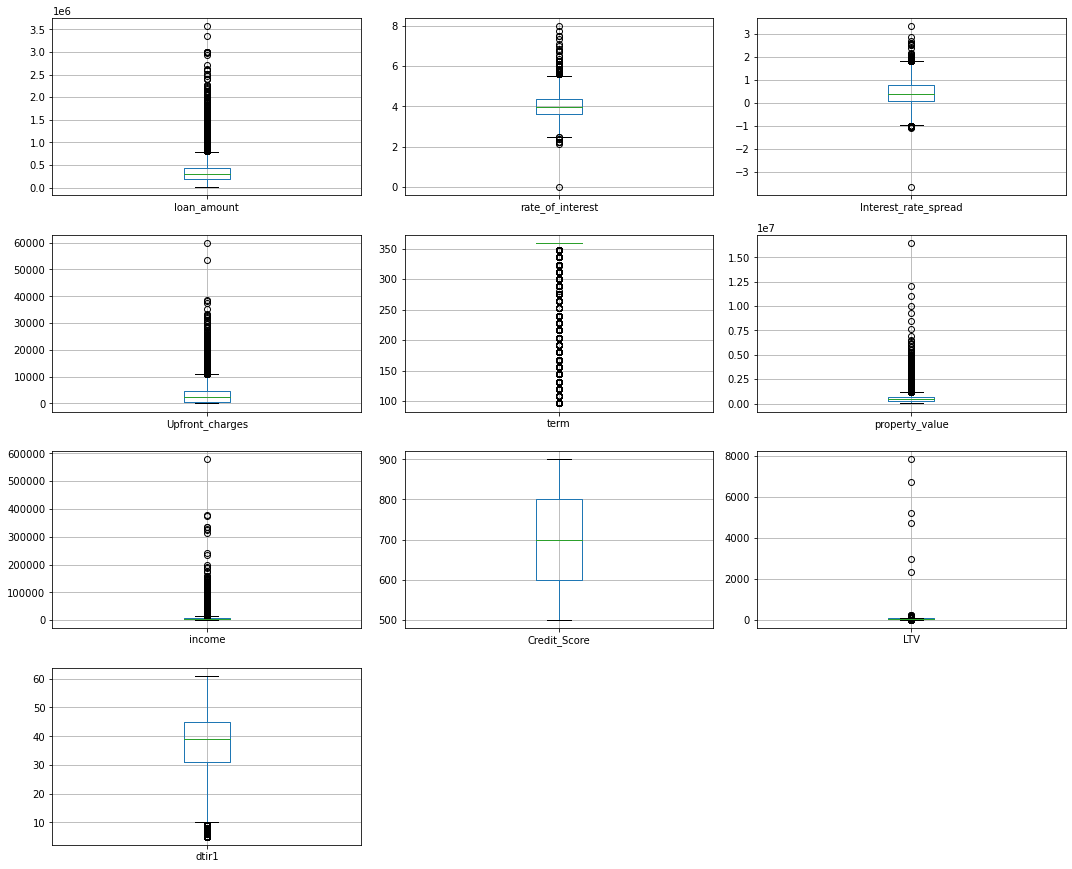

In [12]:
#Understanding the feature set

print('\033[1mFeatures Distribution'.center(100))

nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    sns.distplot(df[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    df.boxplot(nf[c])
plt.tight_layout()
plt.show()

**Inference:** The data is somewhat normally distributed. And there are many outliers present in the dataset. We shall fix these outliers..

**2. 종속 변수와 설명 변수간의 관계**

**2.1 종속 변수와 범주형 변수간의 관계**

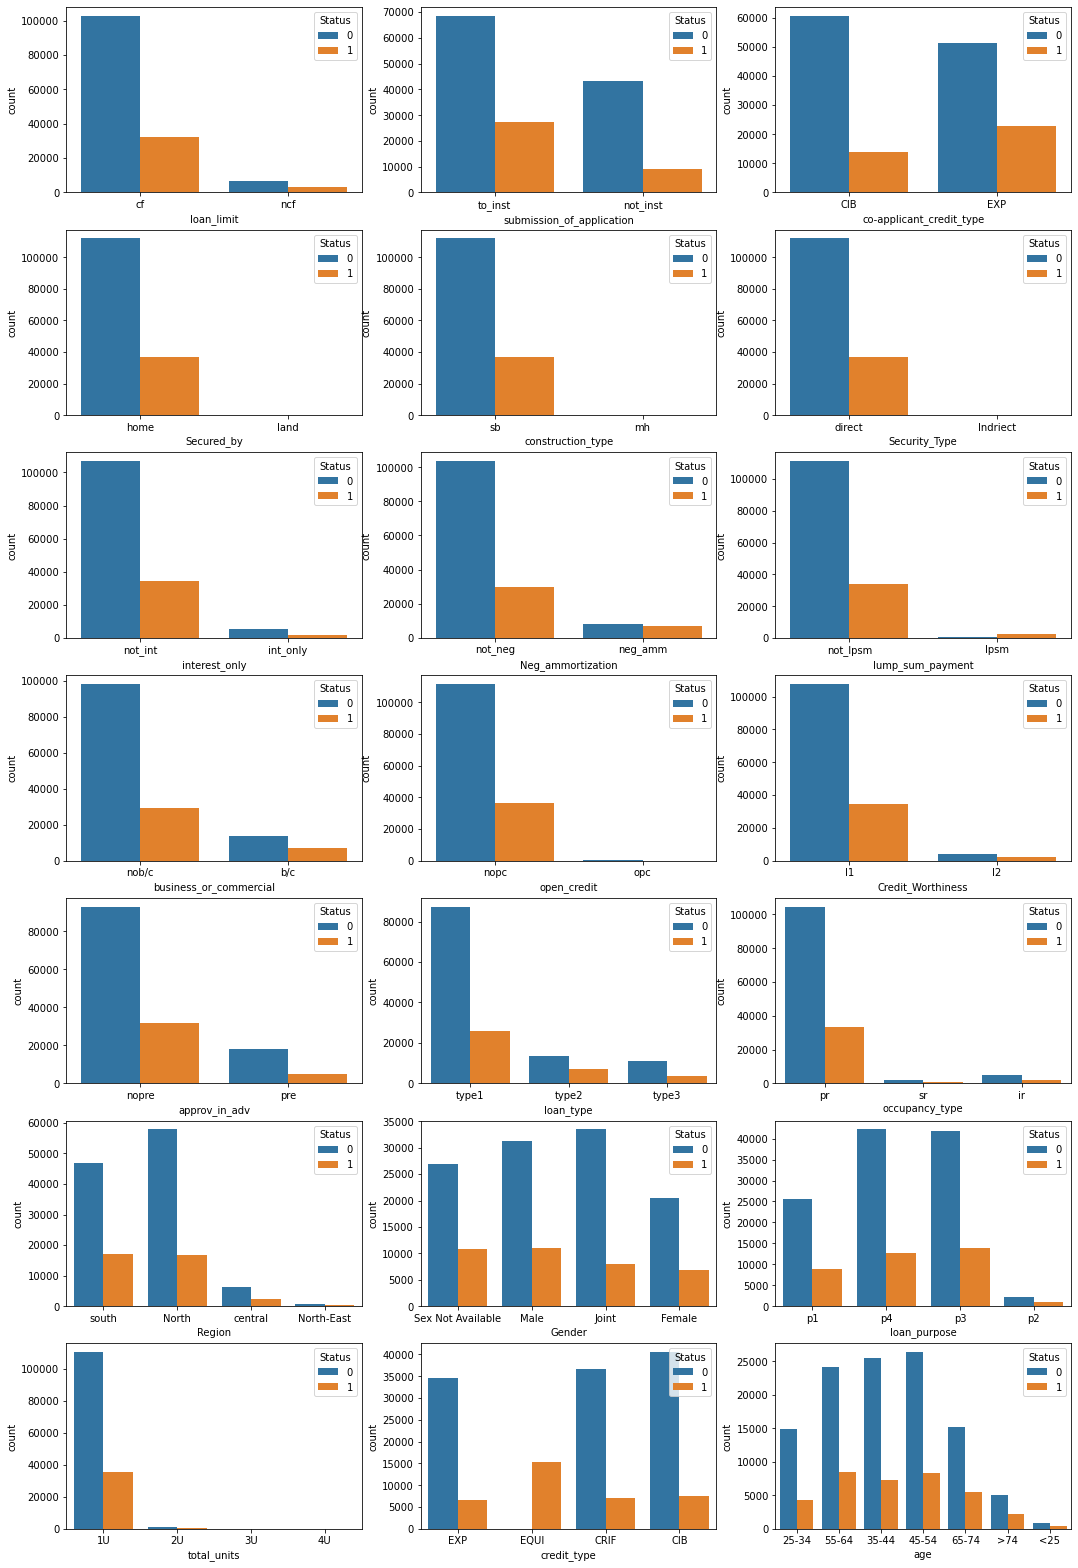

In [13]:
f, axes = plt.subplots(7,3, figsize=[18,4*math.ceil(len(cf)/n)])
axes = axes.flatten()                         
for col, ax in zip(cf, axes):
  sns.countplot(data = df, x=col, hue=target, ax=ax)
plt.show()

NOTE
- 대부분 비체납자의 비율이 체납자의 비율보다 높게 나타났다. 하지만 **credit_type 변수**에서 **'EQUI'**클래스만 체납자의 비율이 높게 나타났다.
- Equipment finance describes a loan or lease that is used to obtain business equipment. Business equipment may be any tangible asset other than real estate – examples include office furniture, computer equipment, machines used in manufacturing, medical equipment, and company vehicles.

**2.2 종속 변수와 연속형 변수간의 관계**

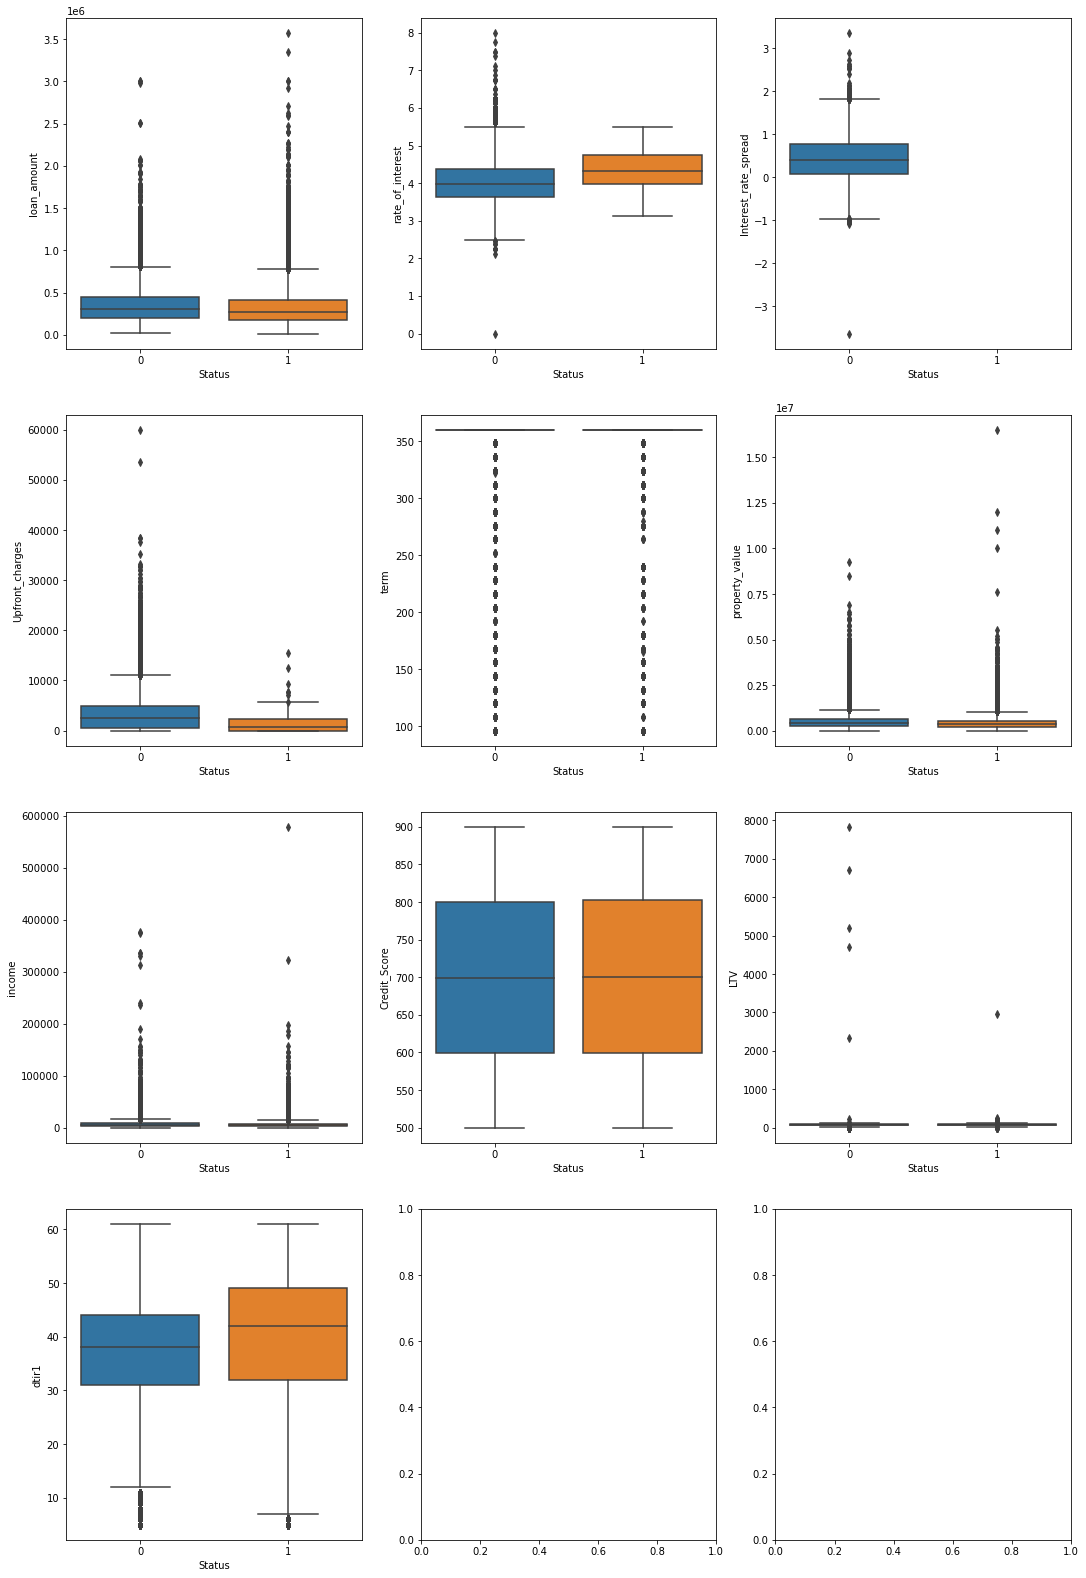

In [14]:
f, axes = plt.subplots(4,3, figsize=[18,4*math.ceil(len(cf)/n)])
axes = axes.flatten()                         
for col, ax in zip(nf, axes):
  sns.boxplot(data = df, x=target, y=col, ax=ax)
plt.show()

In [16]:
condition = (df['Status']==1) & (df['Interest_rate_spread'].isna()==False)
df.loc[condition, ['Status','Interest_rate_spread']]

Empty DataFrame
Columns: [Status, Interest_rate_spread]
Index: []

NOTE
- 'Status'가 1일때 'Interest_rate_spread'는 모두 결측치임

**3. 설명 변수간의 관계**

**3.1 연속형 변수끼리**

In [18]:
# Person 상관계수
corr = df[nf].corr(method = 'pearson')
corr

loan_amount  rate_of_interest  Interest_rate_spread  \
loan_amount              1.000000         -0.150844             -0.377272   
rate_of_interest        -0.150844          1.000000              0.614908   
Interest_rate_spread    -0.377272          0.614908              1.000000   
Upfront_charges          0.065556         -0.076473              0.033037   
term                     0.174474          0.209330             -0.157139   
property_value           0.734249         -0.122613             -0.334571   
income                   0.456065         -0.041809             -0.151333   
Credit_Score             0.004438         -0.001331             -0.001738   
LTV                      0.038869         -0.000220              0.040257   
dtir1                    0.015029          0.055124              0.078178   

                      Upfront_charges      term  property_value    income  \
loan_amount                  0.065556  0.174474        0.734249  0.456065   
rate_of_interest            -0.076473  0.209330       -0.122613 -0.041809   
Interest_rate_spread         0.033037 -0.157139       -0.334571 -0.151333   
Upfront_charges              1.000000 -0.054960        0.053043  0.016580   
term                        -0.054960  1.000000        0.045117 -0.053785   
property_value               0.053043  0.045117        1.000000  0.414883   
income                       0.016580 -0.053785        0.414883  1.000000   
Credit_Score                -0.001484 -0.003149        0.002430  0.000802   
LTV                         -0.031347  0.106834       -0.215102 -0.066203   
dtir1                        0.000115  0.110572       -0.056288 -0.267807   

                      Credit_Score       LTV     dtir1  
loan_amount               0.004438  0.038869  0.015029  
rate_of_interest         -0.001331 -0.000220  0.055124  
Interest_rate_spread     -0.001738  0.040257  0.078178  
Upfront_charges          -0.001484 -0.031347  0.000115  
term                     -0.003149  0.106834  0.110572  
property_value            0.002430 -0.215102 -0.056288  
income                    0.000802 -0.066203 -0.267807  
Credit_Score              1.000000 -0.005533 -0.000313  
LTV                      -0.005533  1.000000  0.156557  
dtir1                    -0.000313  0.156557  1.000000

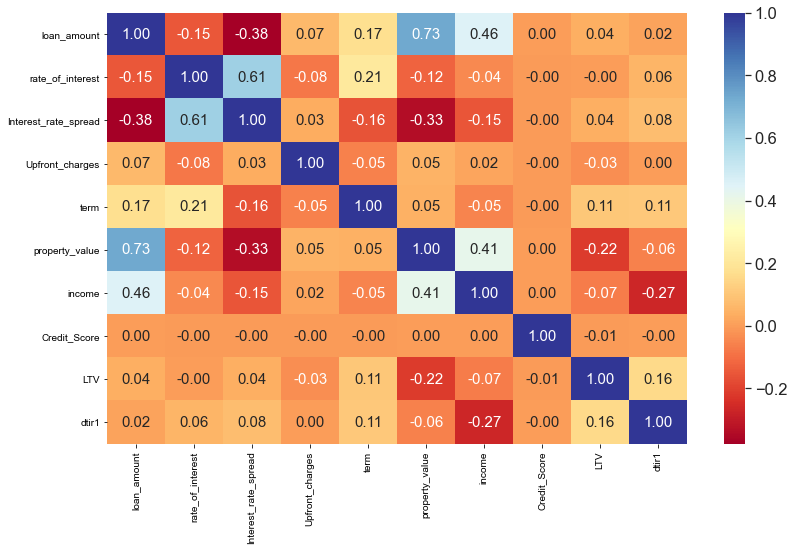

In [19]:
# heatmap (seaborn)
fig = plt.figure(figsize = (12, 8))
ax = fig.gca()

sns.set(font_scale = 1.5)  # heatmap 안의 font-size 설정
heatmap = sns.heatmap(corr.values, annot = True, fmt='.2f', annot_kws={'size':15},
                      yticklabels = nf, xticklabels = nf, ax=ax, cmap = "RdYlBu")
plt.tight_layout()
plt.show()

NOTE
- **loan_amount(대출총액)**와 **property_value(재산)**의 상관계수가 0.73으로 강한 상관관계를 띄고 있다.
- **loan_amount(대출총액)**와 **income(수입)**의 상관계수가 0.46으로 약한 양의 상관관계를 띄고 있다.
- **income(수입)**과 **property_value(재산)**의 상관관계 계수 역시 0.41로 약한 양의 상관관계를 띄고 있다.
- **Interest_rate_spread(순이자스프레드?)**와 **rate_of_interest(이자율)**의 상관계수가 0.61로 강한 상관관계를 띄고 있다.

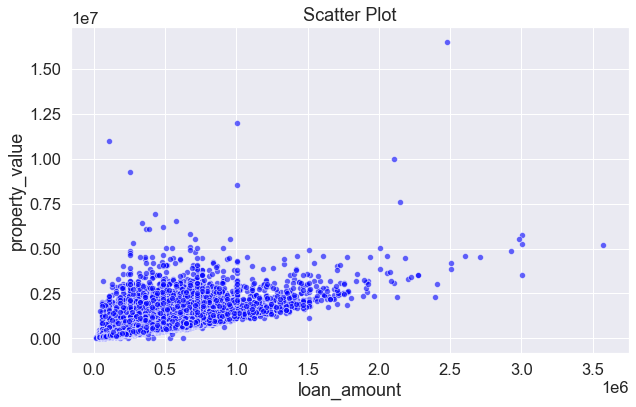

In [15]:
# scatter plot
sns.scatterplot(data=df, x='loan_amount', y='property_value', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

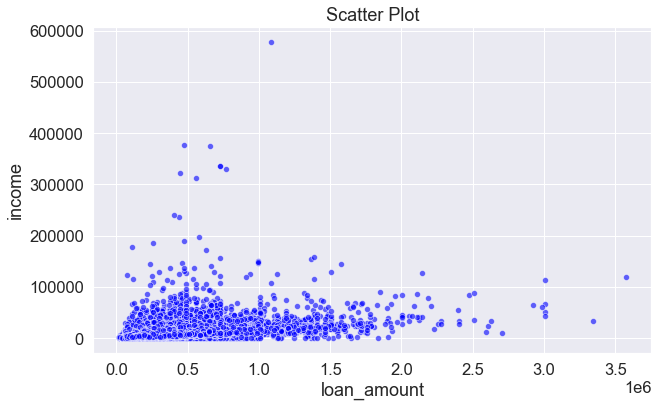

In [20]:
# scatter plot
sns.scatterplot(data=df, x='loan_amount', y='income', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

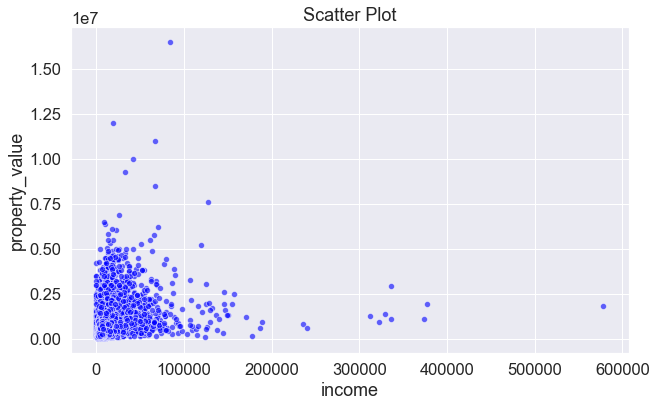

In [21]:
# scatter plot
sns.scatterplot(data=df, x='income', y='property_value', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014391A98430>,
      dtype=object)

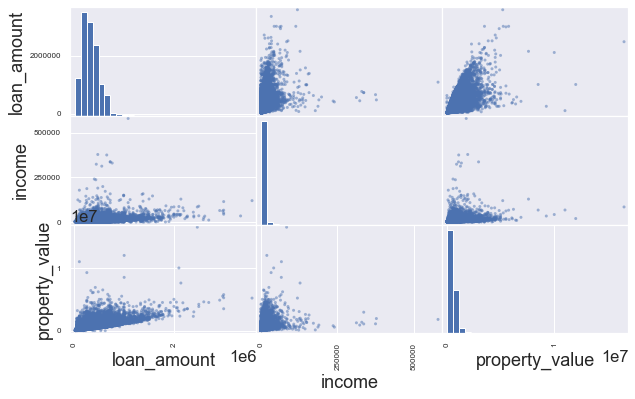

In [37]:
# scatter plot
pd.plotting.scatter_matrix(df[['loan_amount','income','property_value']],hist_kwds={'bins':30})

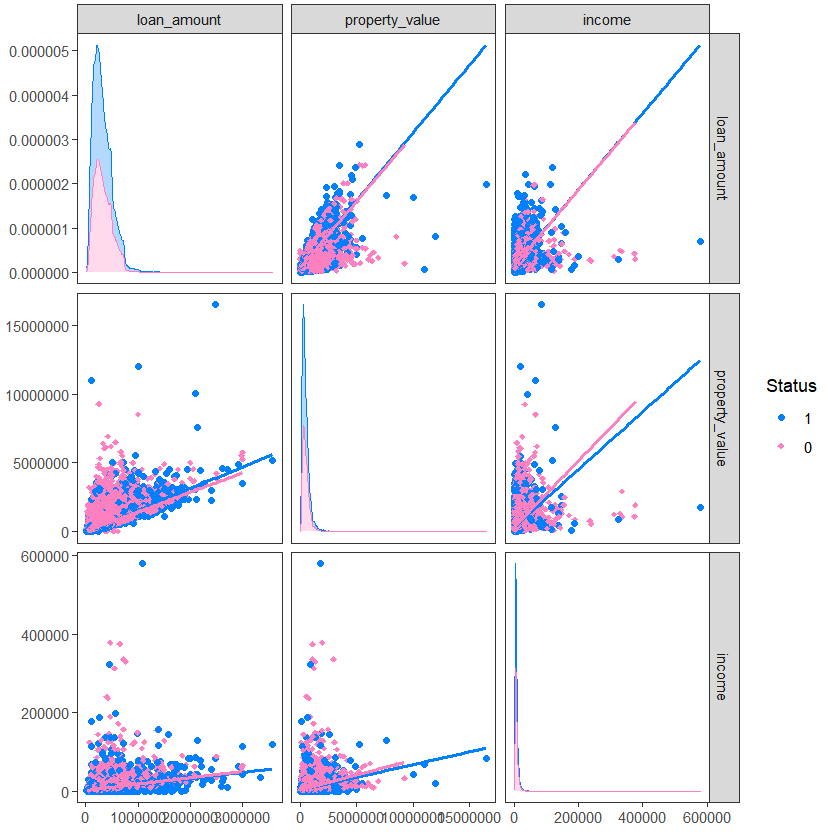

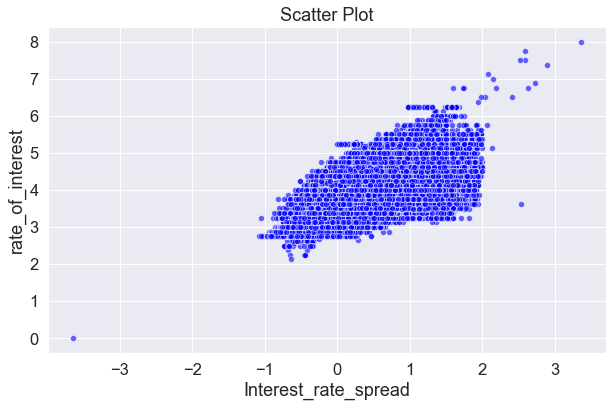

In [16]:
# scatter plot
sns.scatterplot(data=df, x='Interest_rate_spread', y='rate_of_interest', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

NOTE
- 이상치들이 있긴 하지만 scatter plot을 확인하면 양의 상관관계를 띄고있음

# <center> 3. Data Preprocessing

In [38]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [39]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
lump_sum_payment                           0         0.0
co-applicant_credit_type                   0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Status                                     0         0.0
interest_only                              0         0.0
credit_type                                0         0.0
Region                                     0         0.0
Credit_Score                               0         0.0
loan_amount                                0         0.0
business_or_commercial                     0         0.0
open_credit                                0         0.0
Credit_Worthiness                          0         0.0
loan_type                                  0         0.0
Gender                         

**Inference:** There are many outliers in the dataset.

In [40]:
#범주형 변수에 대한 결측치는 모두 삭제처리
df=df.dropna(subset=['Neg_ammortization','loan_purpose','age','submission_of_application','approv_in_adv','loan_limit'])

In [41]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
loan_limit                                 0         0.0
Security_Type                              0         0.0
Region                                     0         0.0
submission_of_application                  0         0.0
age                                        0         0.0
co-applicant_credit_type                   0         0.0
Credit_Score                               0         0.0
credit_type                                0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Status                                     0         0.0
interest_only                              0         0.0
lump_sum_payment                           0         0.0
open_credit                                0         0.0
Gender                         

**연속형 변수의 결측치 처리**
1. 'term', 'income'는 결측률이 낮으므로 행 삭제 처리
2. 'dtir1'은 status에 대해서 크게 상이하게 나타나지 않고 결측률이 높으므로 변수 삭제 처리
3. 'LTV'(주택담보가치 대비 대출이 가능한 금액)와 'property_value'(재산)은 같은 행에서 결측값이 생긴다. 이때 결측률이 높으므로 우선은 그대로 놔둔다.
4. 'rate_of_interest' 와 'Interest_rate_spread'는 같은 행에서 결측값이 생기긴 하지만 앞서 확인한 heatmap에서 강한 상관관계를 띄는 것을 확인 했기 때문에 'Interest_rate_spread'를 변수 삭제처리(이 변수는 status 1일때 무조건 결측치이기 때문에 삭제)하고 나머지 하나는 그대로 놔둔다.
5. 'Upfront_charges'는 상이한가? 상이하면 그대로 둬야하고 아니면 걍 삭제처리-> 삭제하기(결측률이 너무 높음) + 이 변수는 status 1일때 무조건 결측치이기 때문에 삭제

In [135]:
condition = ((df['rate_of_interest'].isna()==True) & (df['Interest_rate_spread'].isna()==True))
df.loc[condition, ['rate_of_interest','Interest_rate_spread']]

rate_of_interest  Interest_rate_spread
0                    NaN                   NaN
1                    NaN                   NaN
10                   NaN                   NaN
12                   NaN                   NaN
15                   NaN                   NaN
...                  ...                   ...
148651               NaN                   NaN
148652               NaN                   NaN
148658               NaN                   NaN
148661               NaN                   NaN
148663               NaN                   NaN

[35270 rows x 2 columns]

In [85]:
df.groupby('Status')['Upfront_charges'].describe()

count         mean          std  min    25%      50%      75%  \
Status                                                                     
0       105659.0  3231.829782  3256.058448  0.0  583.0  2603.75  4826.11   
1            0.0          NaN          NaN  NaN    NaN      NaN      NaN   

            max  
Status           
0       60000.0  
1           NaN

In [77]:
df[['Status','Upfront_charges']]

Status  Upfront_charges
0            1              NaN
1            1              NaN
2            0           595.00
3            0              NaN
4            0             0.00
...        ...              ...
148665       0          9960.00
148666       0             0.00
148667       0          1226.64
148668       0          4323.33
148669       0          6000.00

[143983 rows x 2 columns]

In [42]:
#1. 'term', 'income'는 결측률이 낮으므로 행 삭제 처리
df=df.dropna(subset=['term', 'income'])

In [43]:
#2. 'dtir1'은 status에 대해서 크게 상이하게 나타나지 않고 결측률이 높으므로 변수 삭제 처리
df=df.drop(columns=['dtir1'])

In [44]:
#3. 'rate_of_interest' 와 'Interest_rate_spread'는 같은 행에서 결측값이 생기긴 하지만 앞서 확인한 heatmap에서 강한 상관관계를 띄는 것을 확인 했기 때문에 'Interest_rate_spread'를 변수 삭제처리하고 나머지 하나는 그대로 놔둔다.
df=df.drop(columns=['Interest_rate_spread'])

In [45]:
#5. 'Upfront_charges'는 상이한가? 상이하면 그대로 둬야하고 아니면 걍 삭제처리-> 삭제하기
df=df.drop(columns=['Upfront_charges'])

In [46]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
loan_limit                                 0         0.0
Region                                     0         0.0
submission_of_application                  0         0.0
age                                        0         0.0
co-applicant_credit_type                   0         0.0
Credit_Score                               0         0.0
credit_type                                0         0.0
income                                     0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Security_Type                              0         0.0
Status                                     0         0.0
interest_only                              0         0.0
Neg_ammortization                          0         0.0
term                           

In [47]:
print("결측치 제거 전 샘플 사이즈 : 148670, 결측치 제거 후 샘플 사이즈 : ", df.shape[0])
print("결측치 %d개 제거" %(148670 - df.shape[0]))

결측치 제거 전 샘플 사이즈 : 148670, 결측치 제거 후 샘플 사이즈 :  135108
결측치 13562개 제거


In [54]:
#나머지 결측치에 대해선 simple imputer 적용
from sklearn.impute import SimpleImputer
    
for i in ['LTV','property_value','rate_of_interest']:
    SI = SimpleImputer(strategy='mean')
    df[i] = SI.fit_transform(df[[i]])

In [55]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
loan_limit                                 0         0.0
Region                                     0         0.0
LTV                                        0         0.0
submission_of_application                  0         0.0
age                                        0         0.0
co-applicant_credit_type                   0         0.0
Credit_Score                               0         0.0
credit_type                                0         0.0
income                                     0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Security_Type                              0         0.0
property_value                             0         0.0
interest_only                              0         0.0
Neg_ammortization              

In [56]:
#Converting categorical Columns to Numeric

df1 = df.copy()
ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

#Target Variable
MAP={}
for i,e in enumerate(df1[target].unique()):
    MAP[e]=i
df1[target]=df1[target].map(MAP)
print('Mapping Target variable --->',MAP)

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1m\nOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

Mapping Target variable ---> {1: 0, 0: 1}

One-Hot Encoding on features:
loan_limit
submission_of_application
co-applicant_credit_type
Secured_by
construction_type
Security_Type
interest_only
Neg_ammortization
lump_sum_payment
business_or_commercial
open_credit
Credit_Worthiness
approv_in_adv

Dummy Encoding on features:
loan_type
occupancy_type
Region
Gender
loan_purpose
total_units
credit_type
age


(135108, 46)

In [57]:
df3.head()

loan_limit  approv_in_adv  Credit_Worthiness  open_credit  \
0           0              0                  0            0   
1           0              0                  0            0   
2           0              1                  0            0   
3           0              0                  0            0   
4           0              1                  0            0   

   business_or_commercial  loan_amount  rate_of_interest   term  \
0                       1     116500.0          4.086298  360.0   
1                       0     206500.0          4.086298  360.0   
2                       1     406500.0          4.560000  360.0   
3                       1     456500.0          4.250000  360.0   
4                       1     696500.0          4.000000  360.0   

   Neg_ammortization  interest_only  lump_sum_payment  property_value  \
0                  1              1                 1   118000.000000   
1                  1              1                 0   504111.295488   
2                  0              1                 1   508000.000000   
3                  1              1                 1   658000.000000   
4                  1              1                 1   758000.000000   

   construction_type  Secured_by   income  Credit_Score  \
0                  1           0   1740.0           758   
1                  1           0   4980.0           552   
2                  1           0   9480.0           834   
3                  1           0  11880.0           587   
4                  1           0  10440.0           602   

   co-applicant_credit_type  submission_of_application        LTV  \
0                         0                          1  98.728814   
1                         1                          1  71.471044   
2                         0                          1  80.019685   
3                         0                          0  69.376900   
4                         1                          0  91.886544   

   Security_Type  Status  loan_type_type2  loan_type_type3  occupancy_type_pr  \
0              1       0                0                0                  1   
1              1       0                1                0                  1   
2              1       1                0                0                  1   
3              1       1                0                0                  1   
4              1       1                0                0                  1   

   occupancy_type_sr  Region_North-East  Region_central  Region_south  \
0                  0                  0               0             1   
1                  0                  0               0             0   
2                  0                  0               0             1   
3                  0                  0               0             0   
4                  0                  0               0             0   

   Gender_Joint  Gender_Male  Gender_Sex Not Available  loan_purpose_p2  \
0             0            0                         1                0   
1             0            1                         0                0   
2             0            1                         0                0   
3             0            1                         0                0   
4             1            0                         0                0   

   loan_purpose_p3  loan_purpose_p4  total_units_2U  total_units_3U  \
0                0                0               0               0   
1                0                0               0               0   
2                0                0               0               0   
3                0                1               0               0   
4                0                0               0               0   

   total_units_4U  credit_type_CRIF  credit_type_EQUI  credit_type_EXP  \
0               0                 0                 0                1   
1               0                 0                 1 

In [58]:
#Removal of outlier:

df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.20)
        Q3 = df4[i].quantile(0.80)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

loan_limit  approv_in_adv  Credit_Worthiness  open_credit  \
0           0              0                  0            0   
1           0              0                  0            0   
2           0              1                  0            0   
3           0              0                  0            0   
4           0              1                  0            0   

   business_or_commercial  loan_amount  rate_of_interest   term  \
0                       1     116500.0          4.086298  360.0   
1                       0     206500.0          4.086298  360.0   
2                       1     406500.0          4.560000  360.0   
3                       1     456500.0          4.250000  360.0   
4                       1     696500.0          4.000000  360.0   

   Neg_ammortization  interest_only  lump_sum_payment  property_value  \
0                  1              1                 1   118000.000000   
1                  1              1                 0   504111.295488   
2                  0              1                 1   508000.000000   
3                  1              1                 1   658000.000000   
4                  1              1                 1   758000.000000   

   construction_type  Secured_by   income  Credit_Score  \
0                  1           0   1740.0           758   
1                  1           0   4980.0           552   
2                  1           0   9480.0           834   
3                  1           0  11880.0           587   
4                  1           0  10440.0           602   

   co-applicant_credit_type  submission_of_application        LTV  \
0                         0                          1  98.728814   
1                         1                          1  71.471044   
2                         0                          1  80.019685   
3                         0                          0  69.376900   
4                         1                          0  91.886544   

   Security_Type  Status  loan_type_type2  loan_type_type3  occupancy_type_pr  \
0              1       0                0                0                  1   
1              1       0                1                0                  1   
2              1       1                0                0                  1   
3              1       1                0                0                  1   
4              1       1                0                0                  1   

   occupancy_type_sr  Region_North-East  Region_central  Region_south  \
0                  0                  0               0             1   
1                  0                  0               0             0   
2                  0                  0               0             1   
3                  0                  0               0             0   
4                  0                  0               0             0   

   Gender_Joint  Gender_Male  Gender_Sex Not Available  loan_purpose_p2  \
0             0            0                         1                0   
1             0            1                         0                0   
2             0            1                         0                0   
3             0            1                         0                0   
4             1            0                         0                0   

   loan_purpose_p3  loan_purpose_p4  total_units_2U  total_units_3U  \
0                0                0               0               0   
1                0                0               0               0   
2                0                0               0               0   
3                0                1               0               0   
4                0                0               0               0   

   total_units_4U  credit_type_CRIF  credit_type_EQUI  credit_type_EXP  \
0               0                 0                 0                1   
1               0                 0                 1 


Inference: Before removal of outliers, The dataset had 135108 samples.
Inference: After removal of outliers, The dataset now has 100804 samples.


In [59]:
df4.describe()

loan_limit  approv_in_adv  Credit_Worthiness    open_credit  \
count  100804.000000  100804.000000      100804.000000  100804.000000   
mean        0.055543       0.173475           0.036070       0.000625   
std         0.229039       0.378659           0.186465       0.024992   
min         0.000000       0.000000           0.000000       0.000000   
25%         0.000000       0.000000           0.000000       0.000000   
50%         0.000000       0.000000           0.000000       0.000000   
75%         0.000000       0.000000           0.000000       0.000000   
max         1.000000       1.000000           1.000000       1.000000   

       business_or_commercial    loan_amount  rate_of_interest      term  \
count           100804.000000  100804.000000     100804.000000  100804.0   
mean                 0.855442  330377.028689          4.109028     360.0   
std                  0.351656  159988.106920          0.419157       0.0   
min                  0.000000   26500.000000          2.850000     360.0   
25%                  1.000000  206500.000000          3.875000     360.0   
50%                  1.000000  306500.000000          4.086298     360.0   
75%                  1.000000  436500.000000          4.375000     360.0   
max                  1.000000  896500.000000          5.250000     360.0   

       Neg_ammortization  interest_only  lump_sum_payment  property_value  \
count      100804.000000  100804.000000     100804.000000    1.008040e+05   
mean            0.910371       0.955041          0.974545    4.671790e+05   
std             0.285651       0.207214          0.157504    2.263032e+05   
min             0.000000       0.000000          0.000000    2.800000e+04   
25%             1.000000       1.000000          1.000000    2.880000e+05   
50%             1.000000       1.000000          1.000000    4.580000e+05   
75%             1.000000       1.000000          1.000000    5.880000e+05   
max             1.000000       1.000000          1.000000    1.268000e+06   

       construction_type     Secured_by         income   Credit_Score  \
count      100804.000000  100804.000000  100804.000000  100804.000000   
mean            0.999772       0.000228    6093.932582     699.468374   
std             0.015104       0.015104    3331.024239     115.922747   
min             0.000000       0.000000       0.000000     500.000000   
25%             1.000000       0.000000    3600.000000     599.000000   
50%             1.000000       0.000000    5460.000000     699.000000   
75%             1.000000       0.000000    7980.000000     800.000000   
max             1.000000       1.000000   17640.000000     900.000000   

       co-applicant_credit_type  submission_of_application            LTV  \
count             100804.000000              100804.000000  100804.000000   
mean                   0.490883                   0.613686      74.404929   
std                    0.499919                   0.486906      15.849639   
min                    0.000000                   0.000000      21.330275   
25%                    0.000000                   0.000000      66.921397   
50%                    0.000000                   1.000000      74.280576   
75%                    1.000000                   1.000000      85.550459   
max                    1.000000                   1.000000     129.081633   

       Security_Type         Status  loan_type_type2  loan_type_type3  \
count  100804.000000  100804.000000    100804.000000    100804.000000   
mean        0.999772       0.744266         0.144558         0.077279   
std         0.015104       0.436275         0.351656         0.267034   
min         0.000000       0.000000         0.000000         0.000000   
25%         1.000000       0.000000         0.000000         0.000000   
50%         1.000000       1.000000         0.000000         0.000000   
75%         1.000000       1.000000         0.000000         0.000000   
max         1.000000       1.000000  

In [61]:
#Checking number of unique rows in each feature

df4.nunique().sort_values()

term                            1
loan_limit                      2
Region_North-East               2
Region_central                  2
Region_south                    2
Gender_Joint                    2
Gender_Male                     2
Gender_Sex Not Available        2
loan_purpose_p2                 2
loan_purpose_p3                 2
loan_purpose_p4                 2
total_units_2U                  2
total_units_3U                  2
total_units_4U                  2
credit_type_CRIF                2
credit_type_EQUI                2
credit_type_EXP                 2
age_35-44                       2
age_45-54                       2
age_55-64                       2
age_65-74                       2
occupancy_type_sr               2
occupancy_type_pr               2
loan_type_type3                 2
loan_type_type2                 2
approv_in_adv                   2
Credit_Worthiness               2
open_credit                     2
business_or_commercial          2
Neg_ammortizat

NOTE
- 결측치 처리후 term은 한가지값만 띄는것으로 확인 -> 삭제처리

In [63]:
df4=df4.drop('term', axis=1)

In [66]:
#Checking number of unique rows in each feature
features2 = [i for i in df4.columns.values if i not in [target]]

nu2 = df4[features2].nunique().sort_values()
nf2 = []; cf2 = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df4[features2].shape[1]):
    if nu2.values[i]<=2:cf2.append(nu2.index[i])
    else: nf2.append(nu2.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf2),len(cf2)))


Inference: The Datset has 6 numerical & 38 categorical features.


In [67]:
#표준편차가 큰 numerical variable 표준화 해주기
from sklearn.preprocessing import StandardScaler

for i in nf2:
    std_scaler = StandardScaler()
    df4[i] = std_scaler.fit_transform(df4[[i]])

In [68]:
df4.describe()

loan_limit  approv_in_adv  Credit_Worthiness    open_credit  \
count  100804.000000  100804.000000      100804.000000  100804.000000   
mean        0.055543       0.173475           0.036070       0.000625   
std         0.229039       0.378659           0.186465       0.024992   
min         0.000000       0.000000           0.000000       0.000000   
25%         0.000000       0.000000           0.000000       0.000000   
50%         0.000000       0.000000           0.000000       0.000000   
75%         0.000000       0.000000           0.000000       0.000000   
max         1.000000       1.000000           1.000000       1.000000   

       business_or_commercial   loan_amount  rate_of_interest  \
count           100804.000000  1.008040e+05      1.008040e+05   
mean                 0.855442  1.102976e-16      1.930548e-15   
std                  0.351656  1.000005e+00      1.000005e+00   
min                  0.000000 -1.899382e+00     -3.003727e+00   
25%                  1.000000 -7.742928e-01     -5.583331e-01   
50%                  1.000000 -1.492433e-01     -5.422903e-02   
75%                  1.000000  6.633212e-01      6.345421e-01   
max                  1.000000  3.538549e+00      2.722074e+00   

       Neg_ammortization  interest_only  lump_sum_payment  property_value  \
count      100804.000000  100804.000000     100804.000000    1.008040e+05   
mean            0.910371       0.955041          0.974545    2.996338e-16   
std             0.285651       0.207214          0.157504    1.000005e+00   
min             0.000000       0.000000          0.000000   -1.940676e+00   
25%             1.000000       1.000000          1.000000   -7.917694e-01   
50%             1.000000       1.000000          1.000000   -4.056096e-02   
75%             1.000000       1.000000          1.000000    5.338926e-01   
max             1.000000       1.000000          1.000000    3.538726e+00   

       construction_type     Secured_by        income  Credit_Score  \
count      100804.000000  100804.000000  1.008040e+05  1.008040e+05   
mean            0.999772       0.000228 -5.535531e-17  3.563564e-16   
std             0.015104       0.015104  1.000005e+00  1.000005e+00   
min             0.000000       0.000000 -1.829456e+00 -1.720709e+00   
25%             1.000000       0.000000 -7.487021e-01 -8.666882e-01   
50%             1.000000       0.000000 -1.903126e-01 -4.040420e-03   
75%             1.000000       0.000000  5.662153e-01  8.672338e-01   
max             1.000000       1.000000  3.466239e+00  1.729882e+00   

       co-applicant_credit_type  submission_of_application           LTV  \
count             100804.000000              100804.000000  1.008040e+05   
mean                   0.490883                   0.613686 -1.310309e-15   
std                    0.499919                   0.486906  1.000005e+00   
min                    0.000000                   0.000000 -3.348652e+00   
25%                    0.000000                   0.000000 -4.721602e-01   
50%                    0.000000                   1.000000 -7.845893e-03   
75%                    1.000000                   1.000000  7.032075e-01   
max                    1.000000                   1.000000  3.449730e+00   

       Security_Type         Status  loan_type_type2  loan_type_type3  \
count  100804.000000  100804.000000    100804.000000    100804.000000   
mean        0.999772       0.744266         0.144558         0.077279   
std         0.015104       0.436275         0.351656         0.267034   
min         0.000000       0.000000         0.000000         0.000000   
25%         1.000000       0.000000         0.000000         0.000000   
50%         1.000000       1.000000         0.000000         0.000000   
75%         1.000000       1.000000         0.000000         0.000000   
max         1.000000       1.000000         1.000000         1.000000   

       occupancy_type_pr  occupancy_type_sr  Region_North-East  \
count      100804.00000

# <center> 5. Logistic Regression Modeling

In [69]:
#Splitting the data intro training & testing sets

df = df4.copy()

X = df.drop([target],axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,y.shape,'\nTraining set  ---> ',X_train.shape,y_train.shape,'\nTesting set   ---> ', X_test.shape,'', y_test.shape)

Original set  --->  (100804, 44) (100804,) 
Training set  --->  (80643, 44) (80643,) 
Testing set   --->  (20161, 44)  (20161,)


In [70]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

lr = sm.Logit(y_train, X_train).fit()

         Current function value: 0.345756
         Iterations: 35


In [71]:
print(lr.summary())

                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:                80643
Model:                          Logit   Df Residuals:                    80601
Method:                           MLE   Df Model:                           41
Date:                Sat, 21 May 2022   Pseudo R-squ.:                  0.3915
Time:                        19:09:35   Log-Likelihood:                -27883.
converged:                      False   LL-Null:                       -45820.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
loan_limit                   -0.5837      0.045    -12.845      0.000      -0.673      -0.495
approv_in_adv                 0.3195      0.031     10.323      0.000       0.259     

In [72]:
# classification result for test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lr.predict(X_test)
prediction = list(map(round, y_pred))

print('accuracy: %.2f' % accuracy_score(y_test, prediction))
print('precision: %.2f' % precision_score(y_test, prediction))
print('recall: %.2f' % recall_score(y_test, prediction))
print('F1: %.2f' % f1_score(y_test, prediction))

accuracy: 0.87
precision: 0.85
recall: 0.99
F1: 0.92


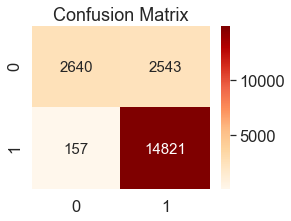

In [73]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = prediction)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [74]:
# AUC Score 확인
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,prediction)

0.7494377373134593

NOTE
- 첫 모델링 결과 auc score는 0.7494을 기록하였다. 따라서, **Plan**에 따라서 다시 모델링을 하려고 한다

**Plan**
- **다중공선성 처리(feature selection)**, **데이터 불균형 처리(resampling)**를 통해서 모델을 2,3차까지 작업한다
- f-1 score와 auc score를 통해서 모델 평가
- final model을 해석한다

## 1. 다중공선성으로 인한 변수 제거(Feature Selection)

참고 : https://signature95.tistory.com/m/18

In [75]:
df.shape[1]

45

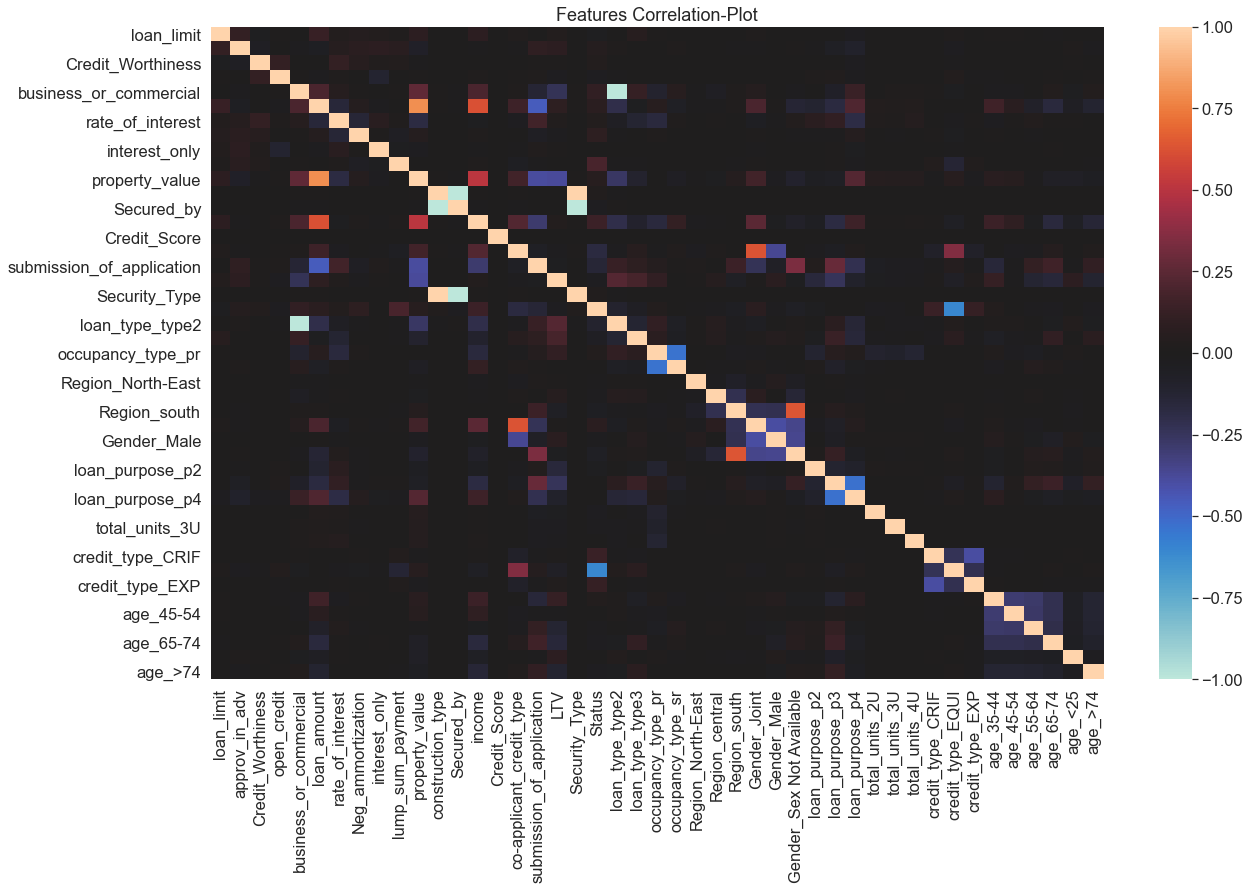

In [76]:
#Checking the correlation

features = df.columns
plt.figure(figsize=[20,12])
plt.title('Features Correlation-Plot')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0) #, 
plt.show()

In [77]:
# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif["features"] = df.columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

VIF Factor                   features
0   2.630607e+12                 Secured_by
1   1.257374e+07            loan_type_type2
2   3.880783e+04     business_or_commercial
3   3.730274e+04          construction_type
4   3.042467e+03              Security_Type
5   6.551787e+00             property_value
6   6.526144e+00                loan_amount
7   3.057069e+00               Gender_Joint
8   2.975255e+00                        LTV
9   2.687327e+00   Gender_Sex Not Available
10  2.496387e+00   co-applicant_credit_type
11  2.207174e+00           credit_type_EQUI
12  2.152347e+00                  age_55-64
13  2.094150e+00                  age_45-54
14  2.025699e+00                  age_35-44
15  2.016792e+00            loan_purpose_p3
16  1.968101e+00                  age_65-74
17  1.958067e+00                     income
18  1.799529e+00                Gender_Male
19  1.796013e+00               Region_south
20  1.736719e+00                     Status
21  1.722080e+00            loan_purpose_p4
22  1.648976e+00          occupancy_type_pr
23  1.629698e+00  submission_of_application
24  1.468131e+00          occupancy_type_sr
25  1.416616e+00                    age_>74
26  1.345971e+00           credit_type_CRIF
27  1.333790e+00            credit_type_EXP
28  1.247093e+00            loan_type_type3
29  1.218806e+00           rate_of_interest
30  1.149141e+00            loan_purpose_p2
31  1.078728e+00              approv_in_adv
32  1.074573e+00                    age_<25
33  1.061293e+00             Region_central
34  1.055989e+00                 loan_limit
35  1.054458e+00          Neg_ammortization
36  1.053501e+00           lump_sum_payment
37  1.044735e+00          Credit_Worthiness
38  1.035518e+00                open_credit
39  1.029157e+00              interest_only
40  1.027326e+00             total_units_4U
41  1.026185e+00             total_units_2U
42  1.016366e+00             total_units_3U
43  1.011528e+00          Region_North-East
44  1.000512e+00               Credit_Score

NOTE:상위 5개 변수에서 다중공선성을 확인할 수 있었다. 이때, 한꺼번에 drop을 하면 정보의 손실이 크게 발생할 수 있으므로 함수를 정의하여 하나씩 제거하기로 하여 vif를 다시 계산하는 단계를 거치기로 함

In [78]:
def vif(x):
    # vif 10 초과시 drop을 위한 임계값 설정
    thresh = 10
    # Filter method로 feature selection 진행 후 최종 도출 될 데이터 프레임 형성
    output = pd.DataFrame()
    # 데이터의 컬럼 개수 설정
    k = x.shape[1]
    # VIF 측정
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1,k):
        print(f'{i}번째 VIF 측정')
        # VIF 최대 값 선정
        a = np.argmax(vif)
        print(f'Max VIF feature & value : {x.columns[a]}, {vif[a]}')
        # VIF 최대 값이 임계치를 넘지 않는 경우 break
        if (vif[a] <= thresh):
            print('\n')
            for q in range(output.shape[1]):
                print(f'{output.columns[q]}의 vif는 {np.round(vif[q],2)}입니다.')
            break
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        if (i == 1):
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 이후 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        elif (i > 1):
            output = output.drop(output.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)

In [79]:
a=vif(df)
a

1번째 VIF 측정
Max VIF feature & value : Secured_by, 2630607258978.0933
2번째 VIF 측정
Max VIF feature & value : construction_type, inf
3번째 VIF 측정
Max VIF feature & value : business_or_commercial, 3844.17656588267
4번째 VIF 측정
Max VIF feature & value : co-applicant_credit_type, 116.86339191470101
5번째 VIF 측정
Max VIF feature & value : interest_only, 27.052868929682404
6번째 VIF 측정
Max VIF feature & value : LTV, 18.539492190033798
7번째 VIF 측정
Max VIF feature & value : Neg_ammortization, 14.19155300446364
8번째 VIF 측정
Max VIF feature & value : rate_of_interest, 8.713986328135297


loan_limit의 vif는 1.12입니다.
approv_in_adv의 vif는 1.29입니다.
Credit_Worthiness의 vif는 1.08입니다.
open_credit의 vif는 1.02입니다.
loan_amount의 vif는 6.47입니다.
rate_of_interest의 vif는 1.18입니다.
Neg_ammortization의 vif는 8.71입니다.
property_value의 vif는 6.55입니다.
income의 vif는 1.88입니다.
Credit_Score의 vif는 1.0입니다.
co-applicant_credit_type의 vif는 4.89입니다.
submission_of_application의 vif는 4.0입니다.
LTV의 vif는 2.91입니다.
Status의 vif는 5.34입니다.
loan_type_type2의 vif는 1.

loan_limit  approv_in_adv  Credit_Worthiness  open_credit  \
0                0              0                  0            0   
1                0              0                  0            0   
2                0              1                  0            0   
3                0              0                  0            0   
4                0              1                  0            0   
...            ...            ...                ...          ...   
100799           0              0                  0            0   
100800           0              0                  0            0   
100801           0              0                  0            0   
100802           0              0                  0            0   
100803           0              0                  0            0   

        loan_amount  rate_of_interest  Neg_ammortization  property_value  \
0         -1.336837         -0.054229                  1       -1.542978   
1         -0.774293         -0.054229                  1        0.163199   
2          0.475806          1.075906                  0        0.180383   
3          0.788331          0.336323                  1        0.843214   
4          2.288450         -0.260114                  1        1.285101   
...             ...               ...                ...             ...   
100799     0.225786         -0.558333                  1        0.843214   
100800     1.975925         -1.154771                  1        1.594422   
100801    -1.399342         -0.054229                  1        0.163199   
100802    -1.086818         -0.283972                  1       -1.366223   
100803     1.600896          2.578929                  1        1.417667   

          income  Credit_Score  co-applicant_credit_type  \
0      -1.307092      0.504922                         0   
1      -0.334413     -1.272133                         1   
2       1.016529      1.160534                         0   
3       1.737032     -0.970206                         0   
4       1.304731     -0.840809                         1   
...          ...           ...                       ...   
100799  0.332052      1.307184                         1   
100800  2.223371      1.496967                         1   
100801 -1.271067     -0.694159                         1   
100802 -0.622614      1.376196                         1   
100803  0.314039     -1.125482                         0   

        submission_of_application       LTV  Status  loan_type_type2  \
0                               1  1.534672       0                0   
1                               1 -0.185108       0                1   
2                               1  0.354253       1                0   
3                               0 -0.317235       1                0   
4                               0  1.102972       1                0   
...                           ...       ...     ...              ...   
100799                          0 -1.180212       1                0   
100800                          0  0.231854       1                0   
100801                          1 -0.185108       0                1   
100802                          1  1.554977       1                1   
100803                          0  0.001515       1                0   

        loan_type_type3  occupancy_type_sr  Region_North-East  Region_central  \
0                     0                  0                  0               0   
1                     0                  0                  0               0   
2                     0                  0                  0               0   
3                     0                  0                  0               0   
4                     0                  0                  0               0   
...                 ...                ...                ...             ...   
100799                0                  0                  0               0   
100800                0         

In [80]:
X = a.drop([target],axis=1)
y = a[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,y.shape,'\nTraining set  ---> ',X_train.shape,y_train.shape,'\nTesting set   ---> ', X_test.shape,'', y_test.shape)

Original set  --->  (100804, 37) (100804,) 
Training set  --->  (80643, 37) (80643,) 
Testing set   --->  (20161, 37)  (20161,)


In [81]:
lr2 = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.370926
         Iterations 13


In [82]:
print(lr2.summary())

                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:                80643
Model:                          Logit   Df Residuals:                    80606
Method:                           MLE   Df Model:                           36
Date:                Sat, 21 May 2022   Pseudo R-squ.:                  0.3472
Time:                        19:20:14   Log-Likelihood:                -29913.
converged:                       True   LL-Null:                       -45820.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
loan_limit                   -0.5324      0.045    -11.933      0.000      -0.620      -0.445
approv_in_adv                 0.4998      0.030     16.398      0.000       0.440     

In [83]:
# classification result for test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lr2.predict(X_test)
prediction = list(map(round, y_pred))

print('accuracy: %.2f' % accuracy_score(y_test, prediction))
print('precision: %.2f' % precision_score(y_test, prediction))
print('recall: %.2f' % recall_score(y_test, prediction))
print('F1: %.2f' % f1_score(y_test, prediction))

accuracy: 0.86
precision: 0.85
recall: 0.98
F1: 0.91


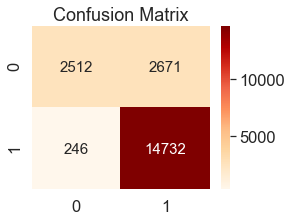

In [84]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = prediction)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [85]:
# AUC Score 확인
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,prediction)

0.7341186521761276

다중공선성을 띄는 총 8개의 변수를 삭제한 후 feature는 36개가 남았다! 하지만, 여전히 차원을 더욱 줄여줄 필요가 있다

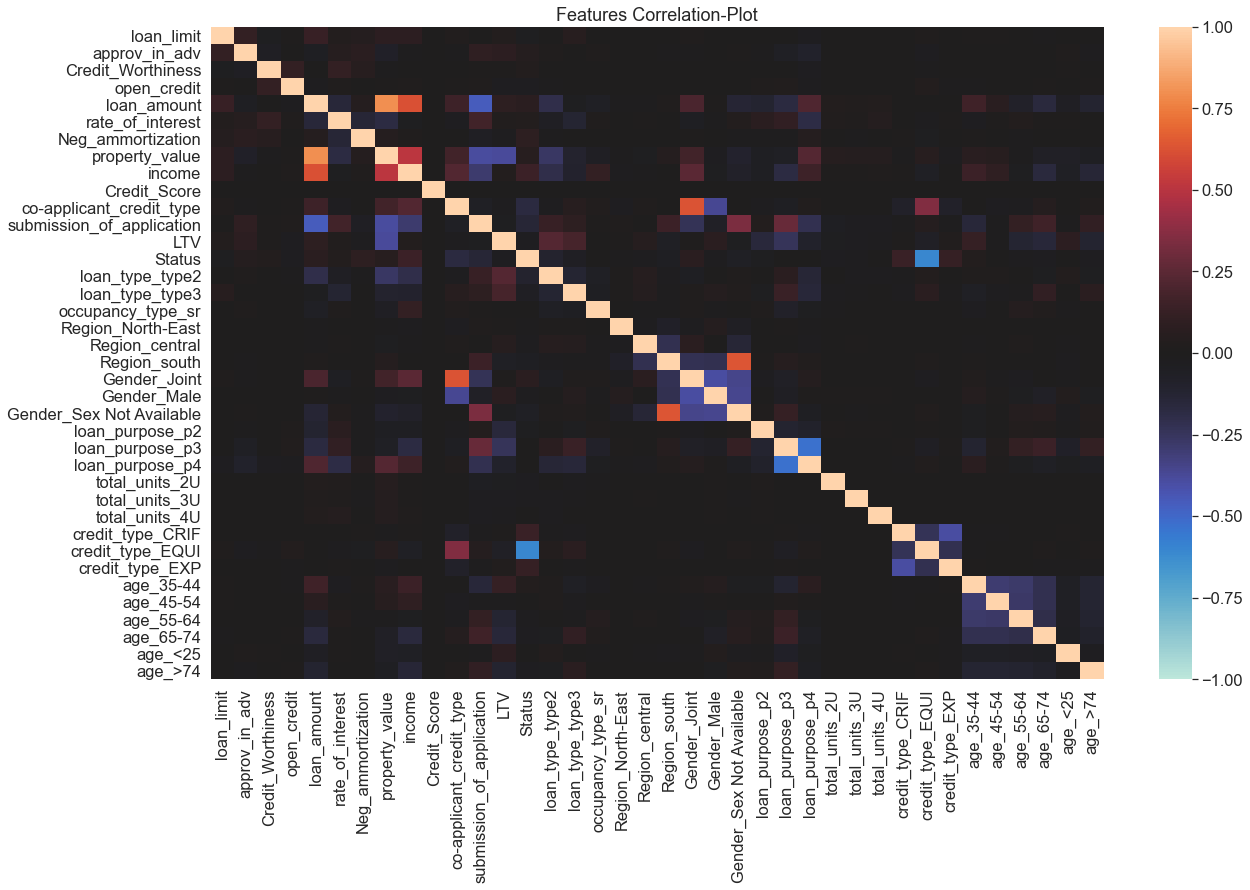

In [86]:
#Checking the correlation

features = a.columns
plt.figure(figsize=[20,12])
plt.title('Features Correlation-Plot')
sns.heatmap(a[features].corr(), vmin=-1, vmax=1, center=0) #, 
plt.show()

NOTE
- EDA로 확인했던 **loan_amount(대출총액)**, **property_value(재산)**, **income(수입)**이 함께 다중공선성을 띌 위험이 있어보인다.
- 따라서, **property_value(재산)** 대비 **loan_amount(대출총액)**인 **loan_property** 변수 생성 후 두 변수는 제거하자.
- **income(수입)** 대비 **loan_amount(대출총액)**인 **loan_income** 변수 생성 후 두 변수는 제거.

In [90]:
a['loan_property']=a['loan_amount']/a['property_value']
a['loan_income']=a['loan_amount']/a['income']

In [91]:
a=a.drop(columns=['loan_amount','property_value','income'],axis=1)

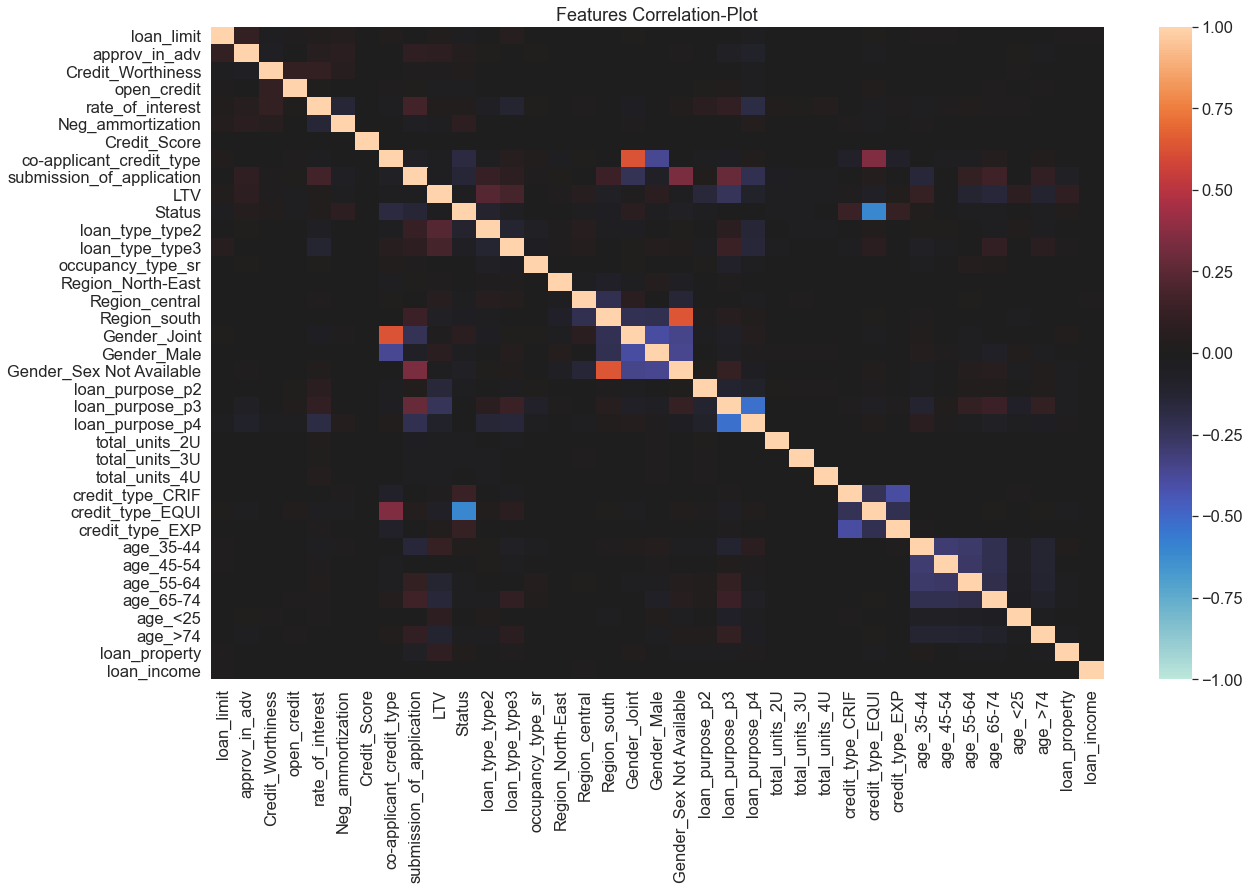

In [92]:
#Checking the correlation

features = a.columns
plt.figure(figsize=[20,12])
plt.title('Features Correlation-Plot')
sns.heatmap(a[features].corr(), vmin=-1, vmax=1, center=0) #, 
plt.show()

In [131]:
a=a.drop(columns=['Gender_Joint','Gender_Male', 'Gender_Sex Not Available','age_35-44', 'age_45-54','age_55-64', 'age_65-74', 'age_<25', 'age_>74','Region_North-East', 'Region_central', 'Region_south'],axis=1)

KeyError: "['Gender_Joint' 'Gender_Male' 'Gender_Sex Not Available' 'age_35-44'\n 'age_45-54' 'age_55-64' 'age_65-74' 'age_<25' 'age_>74'] not found in axis"

In [132]:
a=a.drop(columns=['Region_North-East', 'Region_central', 'Region_south'],axis=1)

In [133]:
X = a.drop([target],axis=1)
y = a[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,y.shape,'\nTraining set  ---> ',X_train.shape,y_train.shape,'\nTesting set   ---> ', X_test.shape,'', y_test.shape)

Original set  --->  (100804, 24) (100804,) 
Training set  --->  (80643, 24) (80643,) 
Testing set   --->  (20161, 24)  (20161,)


In [134]:
lr2_2 = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.380123
         Iterations 13


In [135]:
print(lr2_2.summary())

                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:                80643
Model:                          Logit   Df Residuals:                    80619
Method:                           MLE   Df Model:                           23
Date:                Sat, 21 May 2022   Pseudo R-squ.:                  0.3310
Time:                        20:53:40   Log-Likelihood:                -30654.
converged:                       True   LL-Null:                       -45820.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
loan_limit                   -0.4246      0.044     -9.724      0.000      -0.510      -0.339
approv_in_adv                 0.5282      0.030     17.438      0.000       0.469     

In [136]:
# classification result for test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lr2_2.predict(X_test)
prediction = list(map(round, y_pred))

print('accuracy: %.2f' % accuracy_score(y_test, prediction))
print('precision: %.2f' % precision_score(y_test, prediction))
print('recall: %.2f' % recall_score(y_test, prediction))
print('F1: %.2f' % f1_score(y_test, prediction))

accuracy: 0.85
precision: 0.85
recall: 0.98
F1: 0.91


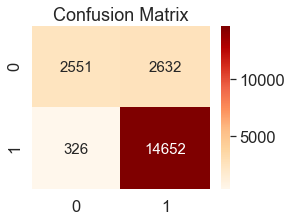

In [137]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = prediction)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [138]:
# AUC Score 확인
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,prediction)

0.7352103684799833

In [139]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#min_features_to_select = 8  # 고려할 최소 설명변수 수
#rfe = RFECV(estimator = LogisticRegression(),min_features_to_select = min_features_to_select)
#fit=rfe.fit(X_train, y_train)

rfe = RFECV(estimator = LogisticRegression(),scoring='accuracy',cv=5)
fit=rfe.fit(X_train, y_train)

In [140]:
fit.n_features_

22

In [141]:
fit.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 3])

In [142]:
X_train.columns

Index(['loan_limit', 'approv_in_adv', 'Credit_Worthiness', 'open_credit',
       'rate_of_interest', 'Neg_ammortization', 'Credit_Score',
       'co-applicant_credit_type', 'submission_of_application', 'LTV',
       'loan_type_type2', 'loan_type_type3', 'occupancy_type_sr',
       'loan_purpose_p2', 'loan_purpose_p3', 'loan_purpose_p4',
       'total_units_2U', 'total_units_3U', 'total_units_4U',
       'credit_type_CRIF', 'credit_type_EQUI', 'credit_type_EXP',
       'loan_property', 'loan_income'],
      dtype='object')

In [115]:
X_train_transform=rfe.transform(X_train)
X_train_transform.shape

(84476, 14)

In [116]:
lr3 = sm.Logit(y_train, X_train_transform).fit()

Optimization terminated successfully.
         Current function value: 0.386976
         Iterations 13


In [117]:
print(lr3.summary())

                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:                84476
Model:                          Logit   Df Residuals:                    84462
Method:                           MLE   Df Model:                           13
Date:                Mon, 16 May 2022   Pseudo R-squ.:                  0.3105
Time:                        23:31:32   Log-Likelihood:                -32690.
converged:                       True   LL-Null:                       -47409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4550      0.041    -11.157      0.000      -0.535      -0.375
x2             0.4720      0.029     16.175      0.000       0.415       0.529
x3             0.6572      0.067      9.824      0.0

***x10 지워줘야하나..?***

In [118]:
# classification result for test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_test_transform=rfe.transform(X_test)

y_pred = lr3.predict(X_test_transform)
prediction = list(map(round, y_pred))

print('accuracy: %.2f' % accuracy_score(y_test, prediction))
print('precision: %.2f' % precision_score(y_test, prediction))
print('recall: %.2f' % recall_score(y_test, prediction))
print('F1: %.2f' % f1_score(y_test, prediction))

accuracy: 0.84
precision: 0.85
recall: 0.96
F1: 0.90


In [119]:
# AUC Score 확인
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,prediction)

0.725410323414152

## 2. 데이터 불균형 처리

In [143]:
# imbalanced-learn 패키지
from imblearn.over_sampling import SMOTE

# 검증 데이터나 테스트 데이터가 아닌 학습데이터에서만 오버샘플링 사용할 것
smote = SMOTE(random_state=11)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [144]:
X_train_over.shape, y_train_over.shape

((120094, 24), (120094,))

In [145]:
lr4 = sm.Logit(y_train_over, X_train_over).fit()

Optimization terminated successfully.
         Current function value: 0.472625
         Iterations 14


In [146]:
print(lr4.summary())

                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:               120094
Model:                          Logit   Df Residuals:                   120070
Method:                           MLE   Df Model:                           23
Date:                Sat, 21 May 2022   Pseudo R-squ.:                  0.3181
Time:                        20:56:34   Log-Likelihood:                -56759.
converged:                       True   LL-Null:                       -83243.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
loan_limit                    0.0490      0.035      1.395      0.163      -0.020       0.118
approv_in_adv                 0.7685      0.022     35.213      0.000       0.726     

- x1 : 대출한도('loan_limit')
- x2 : 승인된 과거이력('approv_in_adv')
- x3 : 신용가치('Credit_Worthiness')
- x4 : 오픈크레딧(사전에 협의된 대출계약)('open_credit')
- x5 : 월납부액이 월이자액보다 작아 미납이자액이 원금에 원가화되어 대출잔액이 최초대출금액보다 증가하는 대출 ('Neg_ammortization')
- x6 : co-applicant와 함께 대출 신청하면 대출 승인 가능성 높일 수 있음 / 대출 조건도 보다 유리함('coapplicant_credit_type'),
- x7 : 신청서 제출('submission_of_application')
- x8 : ('loan_type_type2')
- x9 : (loan_type_type3)
- x10 : ('occupancy_type_sr')
- x11 : ('total_units_2U')
- x12 : ('total_units_3U')
- x13 : ('total_units_4U')
- x14 : 신용형태('credit_type_EQUI')

##### x14의 계수가 유독 크다..? → leverage 확인해야함?

##### target도 변수도 모두 범주형(0,1)일때 어떻게 확인해줘야 하지..?

In [147]:
# classification result for test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#X_test_transform=rfe.transform(X_test)

y_pred = lr4.predict(X_test)
prediction = list(map(round, y_pred))

print('accuracy: %.2f' % accuracy_score(y_test, prediction))
print('precision: %.2f' % precision_score(y_test, prediction))
print('recall: %.2f' % recall_score(y_test, prediction))
print('F1: %.2f' % f1_score(y_test, prediction))

accuracy: 0.81
precision: 0.87
recall: 0.88
F1: 0.87


In [148]:
# AUC Score 확인
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,prediction)

0.7456344486931209

# 피처 셀렉션에서 가변수는 한꺼번에 지워줘야 함?

#### 전체 과정 : 결측치 처리 → 아웃라이어 제거 → scaling → feature selection(다중공선성 처리) → imblance 처리작업 → leverage? → pca?